In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikeras

In [3]:
import pandas as pd
from os import path
x_df = pd.DataFrame()

x_df['sequence'] = pd.read_csv("drive/MyDrive/all_analysis_data.txt", header=None)

In [4]:
y_df = pd.DataFrame()

y_df['labels'] = pd.read_csv("drive/MyDrive/labels.csv", header=None)

y_df.head()

,labels
0,Trojan
1,Trojan
2,Backdoor
3,Backdoor
4,Trojan


In [5]:
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D, LSTM, LeakyReLU, BatchNormalization
from keras.layers import AveragePooling1D, MaxPooling1D, MaxPool1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.regularizers import l1, l2

In [6]:
def cutStream(text):
    words = text.split()[:2000]
    return ' '.join(words)

x_df['cut_seq'] = x_df['sequence'].apply(cutStream)
x_df.drop(columns=['sequence'], inplace=True)

x_df.head()

,cut_seq
0,ldrloaddll ldrgetprocedureaddress ldrloaddll l...
1,getsystemtimeasfiletime ntallocatevirtualmemor...
2,ldrgetdllhandle ldrgetprocedureaddress getsyst...
3,ldrloaddll ldrgetprocedureaddress ldrloaddll l...
4,ldrloaddll ldrgetprocedureaddress ldrgetproced...


In [7]:
# Sample data
data = x_df['cut_seq'].tolist()
labels = y_df['labels'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)


# Vocabulary creation
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_sequence_length = 2000
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_sequence_length, truncating='post')

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [8]:
X_df = pd.DataFrame(padded_sequences)

X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,15,1,15,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,52,9,29,9,16,1,1,1,1,16,...,0,0,0,0,0,0,0,0,0,0
2,16,1,88,23,31,11,6,42,6,18,...,0,0,0,0,0,0,0,0,0,0
3,15,1,15,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,15,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y_df = pd.DataFrame(encoded_labels)

y_df.head()

,0
0,5
1,5
2,1
3,1
4,5


In [10]:
import numpy as np
def create_cnn(cnn_layers, stride, kernel, reg, dropout):
    n_timesteps = X_train.shape[0]
    n_features = X_train.shape[1]
    n_outputs = y_train.shape[0]
    model = Sequential()
    model.add(keras.layers.Embedding(278, 64, input_length=2000))
    model.add(Conv1D(filters=cnn_layers[0], strides=stride, kernel_size=kernel, activation='relu', input_shape=(n_timesteps, n_features)))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(0.5))
    model.add(Dropout(dropout))

    if len(cnn_layers) > 1:
        for i in range(len(cnn_layers)):
            model.add(Conv1D(filters=(cnn_layers[i])*2, strides=stride, kernel_size=kernel, activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.5))
            model.add(Dropout(dropout))
    '''
    model.add(Conv1D(filters=cnn_layers[2], strides=stride, kernel_size=kernel, activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.5))
    model.add(Dropout(dropout))
    '''
    #model.add(Conv1D(filters=1024, strides=stride, kernel_size=kernel, activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
    model.add(MaxPooling1D())
    #
    model.add(GlobalMaxPooling1D())
    model.add(Dense(cnn_layers[-1], activation='relu', kernel_regularizer=l2(reg)))
    model.add(Dense(8, activation='softmax'))

    opt = tf.keras.optimizers.Adam(
        learning_rate=0.002,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state=301)

In [13]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from scipy.stats import wilcoxon


X = X_df.to_numpy()
y = y_df.to_numpy()

# Number of folds
num_folds = 10

# Accuracy scores
accuracy_scores = []

# Initialize lists to store F1 scores for each fold
macro_f1_scores = []
micro_f1_scores = []
weighted_f1_scores = []

# Initialize StratifiedKFold
stratkf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over folds
for train_index, val_index in stratkf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    cnn = create_cnn([64], 4, 4, 0.0001, 0.3)

    cnn.fit(X_train_fold, y_train_fold, verbose=0, epochs=10)

    # Assuming 'lstm' is the trained model
    y_pred = cnn.predict(X_val_fold)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate accuracy values
    accuracy = accuracy_score(y_val_fold, y_pred_labels)

    # Calculate F1 scores for this fold
    macro_f1 = f1_score(y_val_fold, y_pred_labels, average='macro')
    micro_f1 = f1_score(y_val_fold, y_pred_labels, average='micro')
    weighted_f1 = f1_score(y_val_fold, y_pred_labels, average='weighted')

    # Append accuracy to list
    accuracy_scores.append(accuracy)

    # Append F1 scores to the lists
    macro_f1_scores.append(macro_f1)
    micro_f1_scores.append(micro_f1)
    weighted_f1_scores.append(weighted_f1)

    # Print results
    print(f"Accuracy: {accuracy}")
    print(f"Macro F1: {macro_f1}")
    print(f"Micro F1: {micro_f1}")
    print(f"Weighted F1: {weighted_f1}")
    print("-------------------------------")

# Calculate the standard deviation for each metric
accuracy_std = np.std(accuracy_scores)
macro_f1_std = np.std(macro_f1_scores)
micro_f1_std = np.std(micro_f1_scores)
weighted_f1_std = np.std(weighted_f1_scores)

# Print the results
print("Accuracy - Mean:", np.mean(accuracy_scores), "Standard Deviation:", accuracy_std)
print("Macro F1 - Mean:", np.mean(macro_f1_scores), "Standard Deviation:", macro_f1_std)
print("Micro F1 - Mean:", np.mean(micro_f1_scores), "Standard Deviation:", micro_f1_std)
print("Weighted F1 - Mean:", np.mean(weighted_f1_scores), "Standard Deviation:", weighted_f1_std)
print("-------------------------------")

# Print analysis variables
print(f"cnn_acc = {accuracy_scores}")
print(f"cnn_macrof1 = {macro_f1_scores}")
print(f"cnn_microf1 = {micro_f1_scores}")
print(f"cnn_weightedf1 = {weighted_f1_scores}")
print(f"cnn_avg_acc = {np.mean(accuracy_scores)}")
print(f"cnn_acc_std = {accuracy_std}")
print(f"cnn_avg_macrof1 = {np.mean(macro_f1_scores)}")
print(f"cnn_macrof1_std = {macro_f1_std}")
print(f"cnn_avg_microf1 = {np.mean(micro_f1_scores)}")
print(f"cnn_microf1_std = {micro_f1_std}")
print(f"cnn_avg_weightedf1 = {np.mean(weighted_f1_scores)}")
print(f"cnn_weightedf1_std = {weighted_f1_std}")

23/23 [==============================] - 0s 3ms/step
Accuracy: 0.5794655414908579
Macro F1: 0.5806977941520532
Micro F1: 0.5794655414908579
Weighted F1: 0.5711735080379066
-------------------------------
23/23 [==============================] - 0s 2ms/step
Accuracy: 0.5738396624472574
Macro F1: 0.5788971666360715
Micro F1: 0.5738396624472574
Weighted F1: 0.5714209170721231
-------------------------------
23/23 [==============================] - 0s 2ms/step
Accuracy: 0.569620253164557
Macro F1: 0.5724075477508013
Micro F1: 0.569620253164557
Weighted F1: 0.5624980523494081
-------------------------------
23/23 [==============================] - 0s 2ms/step
Accuracy: 0.5541490857946554
Macro F1: 0.5675810077154413
Micro F1: 0.5541490857946554
Weighted F1: 0.5543299408069701
-------------------------------
23/23 [==============================] - 0s 2ms/step
Accuracy: 0.6090014064697609
Macro F1: 0.617431396125786
Micro F1: 0.6090014064697609
Weighted F1: 0.6079410433703576
---------------

In [ ]:
# Hyperparameter optimization
es = EarlyStopping(monitor='loss', patience=3)
cnn_nn = KerasClassifier(model=create_cnn, epochs=10, batch_size=16) # , callbacks=[es])

pipeline_cnn = Pipeline([
    # ('scal', MinMaxScaler()),
    ('cnn', cnn_nn)
])

rkf_cnn = RepeatedKFold(n_splits=2, random_state=2)

# Grid
cnn_layers = [[64], [64,128] ,[64,128,256], [64,128,256,512]]
strides = [4]
kernel = [4]
regs = [0.0001]
dropouts = [0.5, 0.3]

param_cnn = dict(cnn__model__cnn_layers=cnn_layers,
                  cnn__model__stride=strides,
                  cnn__model__kernel=kernel,
                  cnn__model__reg=regs,
                  cnn__model__dropout=dropouts
                  )

search_cnn = GridSearchCV(estimator=pipeline_cnn,
                           param_grid=param_cnn,
                           cv=rkf_cnn,
                           scoring='accuracy')

result_lstm = search_cnn.fit(X_val, y_val)

# print('Best Score: %s' % result_lstm.best_score_)
# print('Best Hyperparameters: %s' % result_lstm.best_params_)

In [ ]:
print('Best Score: %s' % result_lstm.best_score_)
print('Best Hyperparameters: %s' % result_lstm.best_params_)

Best Score: 0.350375
Best Hyperparameters: {'cnn__model__cnn_layers': [64], 'cnn__model__dropout': 0.3, 'cnn__model__kernel': 4, 'cnn__model__reg': 0.0001, 'cnn__model__stride': 4}


In [14]:
cnn = create_cnn([64], 4, 4, 0.0001, 0.3)
# Best Hyperparameters: {'cnn__model__cnn_layers': [64], 'cnn__model__dropout': 0.5, 'cnn__model__kernel': 4, 'cnn__model__reg': 0.0001, 'cnn__model__stride': 4}

print(cnn.summary())

verbose, epochs, batch_size = 1, 10, 32

history = cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose)

test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy}')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 2000, 64)          17792     
                                                                 
 conv1d_11 (Conv1D)          (None, 500, 64)           16448     
                                                                 
 dropout_11 (Dropout)        (None, 500, 64)           0         
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 250, 64)           0         
 ng1D)                                                           
                                                                 
 global_max_pooling1d_11 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_22 (Dense)            (None, 64)              

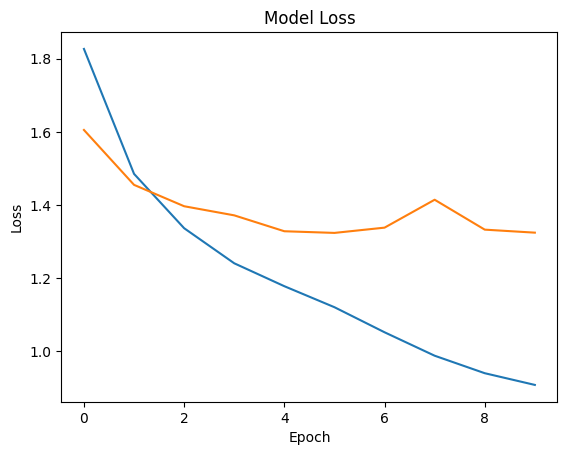

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

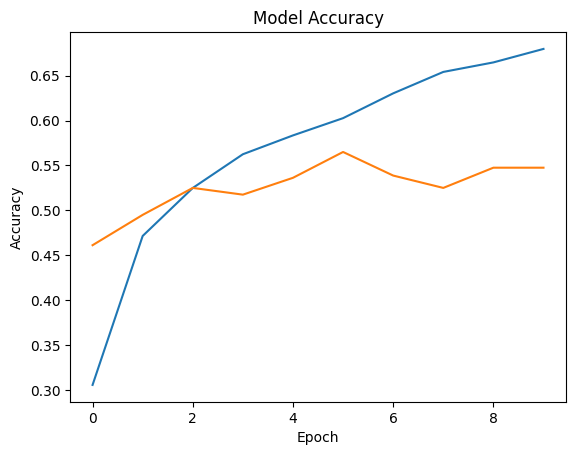

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [17]:
from sklearn.metrics import f1_score

valX_F1 = X_val

y_pred = cnn.predict(X_val)

y_pred_labels = np.argmax(y_pred, axis=1)

macro_f1 = f1_score(y_val, y_pred_labels, average='macro')
micro_f1 = f1_score(y_val, y_pred_labels, average='micro')
weighted_f1 = f1_score(y_val, y_pred_labels, average='weighted')

train_accuracy = history.history.get('accuracy')[-1]

print("Macro F1:", macro_f1)
print("Micro F1:", micro_f1)
print("Weighted F1:", weighted_f1)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

25/25 [==============================] - 0s 2ms/step
Macro F1: 0.5559089401990145
Micro F1: 0.5475
Weighted F1: 0.5474211321663327
Training Accuracy: 0.679690957069397
Test Accuracy: 0.5554304718971252


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

y_true = np.array(y_val)

# Mapping from encoded values to original class names
class_names = label_encoder.classes_

# Convert encoded labels to original class names for visualization
y_true_names = np.array([class_names[label] for label in y_true])
y_pred_names = np.array([class_names[label] for label in y_pred_labels])

# Classification Report
report = classification_report(y_true_names, y_pred_names)
print(report)

              precision    recall  f1-score   support

      Adware       0.66      0.82      0.73        45
    Backdoor       0.54      0.50      0.52       127
  Downloader       0.71      0.57      0.64       122
     Dropper       0.51      0.52      0.52       103
     Spyware       0.35      0.48      0.41        87
      Trojan       0.40      0.33      0.36       108
       Virus       0.73      0.77      0.75       109
       Worms       0.52      0.52      0.52        99

    accuracy                           0.55       800
   macro avg       0.55      0.57      0.56       800
weighted avg       0.55      0.55      0.55       800



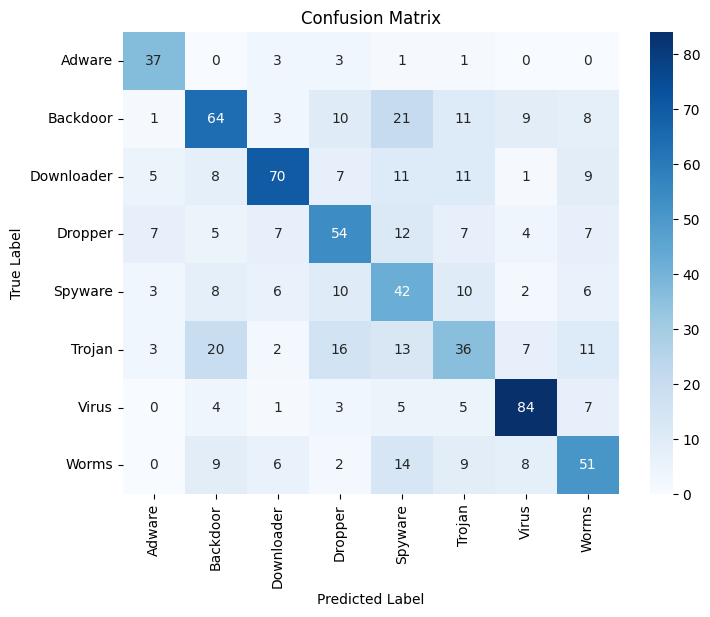

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_names))

# Get class labels
classes = list(class_names)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Save model
cnn.save("/content/drive/MyDrive/SavedModels_Malware")